In [29]:
# define the system
from IPython.display import display
import ipywidgets as ipw
import numpy as np

def y(x):
    return(np.exp(-0.1*x) * np.sin(x))

def Y(s1, s2):
    s = s1 +  1j * s2
    Y = 1 / s # WATCH DIVISION BY ZERO
    return(Y.real, Y.imag)

tArray = np.linspace(0, 10, 100)
s1Array = np.linspace(-10, 10, 100) # make sure both of them don't pass through 0 to avoid infinity
s2Array = np.linspace(-10, 10, 100)

yArray = y(tArray)
Y1Array, Y2Array = Y(s1Array, s2Array)

In [22]:
# sliders styling and whatnot, normally should be hidden from view
tSlider = ipw.FloatSlider(
    value=tArray[0],
    min=np.min(tArray), 
    max=np.max(tArray),
    description='$t$:',
    disabled=False, 
    step=tArray[1] - tArray[0],
    readout=True,
    readout_format='.1f',
    continuous_update=True,
    layout=ipw.Layout(width='100%', height='80px'), 
)

ySlider = ipw.FloatSlider(
    value=yArray[0],
    min=np.min(yArray), 
    max=np.max(yArray),
    description='$y$:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=True,
    layout=ipw.Layout(width='100%', height='80px'), 
)

s1Slider = ipw.FloatSlider(
    value=s1Array[0],
    min=np.min(s1Array), 
    max=np.max(s1Array), 
    description='Real[$s$]:',
    disabled=False,
    step=s1Array[1] - s1Array[0],
    readout=True,
    readout_format='.1f',
    continuous_update=True,
    layout=ipw.Layout(width='50%', height='80px'),  
)

s2Slider = ipw.FloatSlider(
    value=s2Array[0],
    min=np.min(s2Array), 
    max=np.max(s2Array), 
    description='Imag[$s$]:',
    disabled=False,
    step=s2Array[1] - s2Array[0],
    readout=True,
    readout_format='.1f',
    continuous_update=True,
    layout=ipw.Layout(width='50%', height='80px'), 
)

Y1Slider = ipw.FloatSlider(
    value=Y1Array[0],
    min=np.min(Y1Array), 
    max=np.max(Y1Array), 
    description='Real[$Y$]:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=True,
    layout=ipw.Layout(width='50%', height='80px'), 
)

Y2Slider = ipw.FloatSlider(
    value=Y2Array[0],
    min=np.min(Y2Array), 
    max=np.max(Y2Array), 
    description='Imag[$Y$]:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=True,
    layout=ipw.Layout(width='50%', height='80px'), 
)

In [32]:
s1Slider.value = s2Array[0]
s2Slider.value = s1Array[0]
Y1Slider.value = Y1Array[0]
Y2Slider.value = Y2Array[0]


def update_sSliders(s1Value, s2Value):
    s1Slider.value = s1Value
    s2Slider.value = s2Value

def update_YSliders(s1Value, s2Value):
    Y1Value, Y2Value = Y(s1Value, s2Value)
    Y1Slider.value = Y1Value
    Y2Slider.value = Y2Value

def handle_s1Slider(change):
    s1Value = change['new']
    s2Value = s2Slider.value
    update_YSliders(s1Value, s2Value)

def handle_s2Slider(change):
    s1Value = s1Slider.value
    s2Value = change['new'] 
    update_YSliders(s1Value, s2Value)

s1Slider.observe(handle_s1Slider, names='value')    
s2Slider.observe(handle_s2Slider, names='value')   
display(ipw.VBox([ipw.HBox([s1Slider, Y1Slider]), ipw.HBox([s2Slider, Y2Slider])]))

# for some reason doesn't work:
#display(ipw.HBox([ipw.VBox([s1Slider, s2Slider]), ipw.VBox([Y1Slider, Y2Slider])])) 
#display(fig)    

# bqplot slider & plot interaction 

## time->y

In [27]:
import bqplot as bqp
# initialize the sliders and figure
tSlider.value = tArray[0]
ySlider.value = yArray[0]
xSc = bqp.LinearScale()
ySc = bqp.LinearScale()
xAxis = bqp.Axis(label='t', scale=xSc, tick_format='0.0f', grid_lines='none')
yAxis = bqp.Axis(label='y(t)', scale=ySc, orientation='vertical', tick_format='0.2f', grid_lines='none')
line = bqp.Lines(x=tArray, y=yArray, scales={'x': xSc, 'y': ySc}, labels=['y'], display_legend=True)
point = bqp.Scatter(x=[tArray[0]], y=[yArray[0]], scales={'x': xSc, 'y': ySc})
label = bqp.Label(x=[tArray[0]], y=[yArray[0]], scales={'x': xSc, 'y': ySc}, x_offset = 5, y_offset = 5, text=['{:.4f}'.format(yArray[0])])
fig = bqp.Figure(axes=[xAxis, yAxis],  marks=[line, point, label])

def handle_tSlider(change):
    tValue = change['new']
    yValue = y(tValue)
    ySlider.value = yValue
    point.x = [tValue]
    point.y = [yValue]
    label.x = [tValue]
    label.y = [yValue]
    label.text = ['{:.4f}'.format(yValue)]
    
tSlider.observe(handle_tSlider, names='value')

display(ipw.HBox([tSlider, ySlider]))
display(fig)

Figure(axes=[Axis(grid_lines='none', label='t', scale=LinearScale(), tick_format='0.0f'), Axis(grid_lines='non…

## COMPARISON: matplotlib slider & plot interaction 

In [5]:
from matplotlib import pyplot as plt
#%matplotlib inline # DOES NOT WORK/UPDATE
%matplotlib widget
fig = plt.figure()
ax = fig.gca()
hPlot = ax.plot(tArray, yArray, linewidth=2, label='$y$');
hScatter = ax.scatter(tArray[0], yArray[0], 50)
hText = ax.text(tArray[0], yArray[0], ' ${:.3f}$'.format(yArray[0]))
ax.set_xlabel('$t$');
ax.set_ylabel('$y(t)$');
plt.legend(loc="best");

def handle_tSlider_change(change): 
    tValue = change['new']
    yValue = y(tValue)
    ySlider.value = yValue
    hScatter.set_offsets((tValue, yValue))
    hText.set_position((tValue, yValue))
    hText.set_text(' ${:.3f}$'.format(yValue))
tSlider.observe(handle_tSlider_change, names='value')

display(ipw.HBox([tSlider, ySlider]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## s->Y

# linking widgets

In [13]:
a = ipw.FloatText()
b = ipw.FloatSlider()
display(a,b)

mylink = ipw.jslink((a, 'value'), (b, 'value'))

FloatText(value=0.0)

FloatSlider(value=0.0)

# sympy laplace transform test

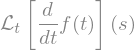

In [15]:
import sympy as sy
from sympy.abc import t, s, a
sy.init_printing()
f = sy.Function('f')
sy.laplace_transform(f(t).diff(), t, s)

# draggable bqplot 


In [14]:
s = bqp.Scatter(x=[0], y=[0], scales=dict(x=bqp.LinearScale(), y=bqp.LinearScale()), enable_move=True)
bqp.Figure(marks=[s])

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, marks=[Scatter(colors=['steelblue'], ena…

https://stackoverflow.com/questions/46495049/bqplot-performance-issue

In [16]:
from bqplot import pyplot as plt
from ipywidgets import jslink

fig = plt.figure()

# Strange bug when 1st point is 0,0. Red point flickers.  
lin=plt.plot([0.0001,1],
             [0.0001,0])   

scatt2=plt.scatter(lin.x, lin.y, enable_move = True, colors = ['Red','blue'])
scatt2.update_on_move = True

# Cover up 1st point so it can't be moved. 
# Just remove this line if you want both points to be moveable
scatt3=plt.scatter([lin.x[0]], [lin.y[0]], colors = ['Red']) 


plt.xlim(-3,3)
plt.ylim(-3,3)
fig.layout.height = '500px'
fig.layout.width = '500px'
plt.show()

jslink((scatt2, 'x'), (lin, 'x'))
jslink((scatt2, 'y'), (lin, 'y'))

Link(source=(Scatter(colors=['Red', 'blue'], enable_move=True, interactions={'hover': 'tooltip'}, scales={'x':…

# draggable points in matplotlib example 
https://stackoverflow.com/questions/50439506/dragging-points-in-matplotlib-interactive-plot

In [33]:
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.interpolate as inter
import numpy as np

func = lambda x: 0.1*x**2

#get a list of points to fit a spline to as well
N = 10
xmin = 0 
xmax = 10 
x = np.linspace(xmin,xmax,N)

#spline fit
yvals = func(x)
spline = inter.InterpolatedUnivariateSpline (x, yvals)

#figure.subplot.right
mpl.rcParams['figure.subplot.right'] = 0.8

#set up a plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


pind = None #active point
epsilon = 5 #max pixel distance

def update(val):
    global yvals
    global spline
    # update curve
    for i in np.arange(N):
      yvals[i] = sliders[i].val 
    l.set_ydata(yvals)
    spline = inter.InterpolatedUnivariateSpline (x, yvals)
    m.set_ydata(spline(X))
    # redraw canvas while idle
    fig.canvas.draw_idle()

def reset(event):
    global yvals
    global spline
    #reset the values
    yvals = func(x)
    for i in np.arange(N):
      sliders[i].reset()
    spline = inter.InterpolatedUnivariateSpline (x, yvals)
    l.set_ydata(yvals)
    m.set_ydata(spline(X))
    # redraw canvas while idle
    fig.canvas.draw_idle()

def button_press_callback(event):
    'whenever a mouse button is pressed'
    global pind
    if event.inaxes is None:
        return
    if event.button != 1:
        return
    #print(pind)
    pind = get_ind_under_point(event)    

def button_release_callback(event):
    'whenever a mouse button is released'
    global pind
    if event.button != 1:
        return
    pind = None

def get_ind_under_point(event):
    'get the index of the vertex under point if within epsilon tolerance'

    # display coords
    #print('display x is: {0}; display y is: {1}'.format(event.x,event.y))
    t = ax1.transData.inverted()
    tinv = ax1.transData 
    xy = t.transform([event.x,event.y])
    #print('data x is: {0}; data y is: {1}'.format(xy[0],xy[1]))
    xr = np.reshape(x,(np.shape(x)[0],1))
    yr = np.reshape(yvals,(np.shape(yvals)[0],1))
    xy_vals = np.append(xr,yr,1)
    xyt = tinv.transform(xy_vals)
    xt, yt = xyt[:, 0], xyt[:, 1]
    d = np.hypot(xt - event.x, yt - event.y)
    indseq, = np.nonzero(d == d.min())
    ind = indseq[0]

    #print(d[ind])
    if d[ind] >= epsilon:
        ind = None

    #print(ind)
    return ind

def motion_notify_callback(event):
    'on mouse movement'
    global yvals
    if pind is None:
        return
    if event.inaxes is None:
        return
    if event.button != 1:
        return

    #update yvals
    #print('motion x: {0}; y: {1}'.format(event.xdata,event.ydata))
    yvals[pind] = event.ydata 

    # update curve via sliders and draw
    sliders[pind].set_val(yvals[pind])
    fig.canvas.draw_idle()

X = np.arange(0,xmax+1,0.1)
ax1.plot (X, func(X), 'k--', label='original')
l, = ax1.plot (x,yvals,color='k',linestyle='none',marker='o',markersize=8)
m, = ax1.plot (X, spline(X), 'r-', label='spline')



ax1.set_yscale('linear')
ax1.set_xlim(0, xmax)
ax1.set_ylim(0,xmax)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':22})

sliders = []

for i in np.arange(N):

    axamp = plt.axes([0.84, 0.8-(i*0.05), 0.12, 0.02])
    # Slider
    s = Slider(axamp, 'p{0}'.format(i), 0, 10, valinit=yvals[i])
    sliders.append(s)


for i in np.arange(N):
    #samp.on_changed(update_slider)
    sliders[i].on_changed(update)

axres = plt.axes([0.84, 0.8-((N)*0.05), 0.12, 0.02])
bres = Button(axres, 'Reset')
bres.on_clicked(reset)

fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

https://stackoverflow.com/questions/44657772/tighter-layout-of-bqplot-figures-in-jupyter

# bqplot label example

In [29]:
from bqplot import Label, LinearScale, Axis, Lines, Figure, DateScale
import numpy as np
import pandas as pd
np.random.seed(10)
price_data = pd.DataFrame(np.cumsum(np.random.randn(150, 2).dot([[0.5, 0.8], [0.8, 1.0]]), axis=0) + 100,
                          columns=['Security 1', 'Security 2'],
                          index=pd.date_range(start='01-01-2007', periods=150))
y_data = np.cumsum(np.random.randn(100))
x_sc = LinearScale()
y_sc = LinearScale()

test_line = Lines(x=np.arange(10), y=y_data[:10], scales={'x': x_sc, 'y': y_sc})
test_label = Label(x=np.arange(5), y=y_data[:5], scales={'x': x_sc, 'y': y_sc},
                   text=['Test', 'Label', 'for', 'the', 'Data'], default_size=26, font_weight='bolder',
                   colors=['orange', 'red'], update_on_move=True)

ax_x = Axis(scale=x_sc, label='X')
ax_y = Axis(scale=y_sc, orientation='vertical', tick_format='0.2f', label='Y')

Figure(marks=[test_label, test_line], axes=[ax_x, ax_y], title='Basic Label Example')

Figure(axes=[Axis(label='X', scale=LinearScale()), Axis(label='Y', orientation='vertical', scale=LinearScale()…

# other notes

In [35]:
import matplotlib.pyplot as plt
%matplotlib widget
def fun(x, y):
    x, y = Y(x, y)
    return np.sqrt(x**2 + y**2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(s1Array, s2Array)
zs = np.array(fun(np.ravel(x), np.ravel(y)))
z = zs.reshape(x.shape)
ax.plot_surface(x, y, z)
ax.set_zlim(0, 5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
import ipywidgets as widgets

out = widgets.Output()
def on_value_change(change):
    with out:
        print(change['new'])

slider = widgets.IntSlider(min=1, max=100, step=1, continuous_update=True)
play = widgets.Play(min=1, interval=2000)

slider.observe(on_value_change, 'value')
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.VBox([play, slider, out])